## Discretización utilizando árboles de decisión y Feature-engine

Feature Engine permite implementar la discretización con árboles de decisión en todas las variables numéricas muy fácilmente, incluyendo la búsqueda de múltiple parámetros del árbol para encontrar el mejor.

## En este demo

Aprenderás como discretizar con los árboles de decisión usando Feature-engine y los datos del Titanic 

### Titanic dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.discretisers import DecisionTreeDiscretiser

In [2]:
# cargar variables numéricas Titanic Dataset

data = pd.read_csv('../titanic.csv',
                   usecols = ['age', 'fare', 'survived'])

data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
# separemos sets entrenamiento y prueba 

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

Las variables age y fare contienen datos faltantes. Los vamos a completar extrayendo una muestra aleatoria de la variable.

In [4]:
def impute_na(data, variable):
    
    # función para reemplazar NA con una muestra aleatoria

    df = data.copy()

    # muestra aleatoria
    df[variable+'_aleatoria'] = df[variable]

     # extraer muestra aleatoria para completar datos faltantes na
    random_sample = X_train[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)

    # pandas necesita tener el mismo index para poder 
    # combinar los dataframes
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_aleatoria'] = random_sample

    return df[variable+'_aleatoria']

In [5]:
# reemplazar los NA en sets de entrenamiento y prueba

X_train['age'] = impute_na(data, 'age')
X_test['age'] = impute_na(data, 'age')

X_train['fare'] = impute_na(data, 'fare')
X_test['fare'] = impute_na(data, 'fare')

In [6]:
X_train.head()

,age,fare
501,13.0,19.5000
588,4.0,23.0000
402,30.0,13.8583
1193,21.0,7.7250
686,22.0,7.7250


In [7]:
# construir un árbol de clasificación indicando:
# número de validación cruzada (cv)
# cómo evaluar el desempeño del modelo (scoring)
# las variables que queremos discretizar (variables)
# definir si es un target para regresión o clasificación
# y la cuadrícula con los parámetros que queremos evaluar 

treeDisc = DecisionTreeDiscretiser(cv=10, scoring='accuracy',
                                   variables=['age', 'fare'],
                                   regression=False,
                                   param_grid={'max_depth': [1, 2, 3],
                                              'min_samples_leaf':[10,4]})

treeDisc.fit(X_train, y_train)

DecisionTreeDiscretiser(cv=10,
                        param_grid={'max_depth': [1, 2, 3],
                                    'min_samples_leaf': [10, 4]},
                        random_state=None, regression=False, scoring='accuracy',
                        variables=['age', 'fare'])

In [8]:
# podemos inspeccionar el árbol para la variable age
treeDisc.binner_dict_['age'].best_params_

{'max_depth': 2, 'min_samples_leaf': 4}

In [9]:
# y el desempeño obtenido con el set de entrenamiento mientras se ajusta el árbol
treeDisc.scores_dict_['age']

0.618995633187773

In [10]:
# y los mejores parámetros para fare
treeDisc.binner_dict_['fare'].best_params_

{'max_depth': 3, 'min_samples_leaf': 10}

In [11]:
# y el desempeño obtenido en el set de entrenamiento mientras se ajusta el árbol

treeDisc.scores_dict_['fare']

0.6888646288209607

Comparando la precisión de los árboles de decisión para las variables age y fare, podemos derivar que fare is mejor indicador/predictor del target -  supervivencia en el titanic

In [12]:
# transformamos los datos

train_t = treeDisc.transform(X_train)
test_t = treeDisc.transform(X_test)

In [13]:
# inspeccionemos cuantos intervalos encontramos
train_t['age'].unique()

array([0.38011696, 0.53846154, 0.        ])

Text(0, 0.5, 'Survived')

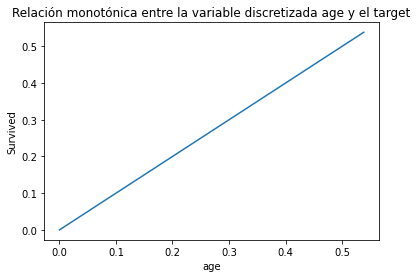

In [14]:
# Relación monotónica con el target: set entrenamiento

pd.concat([train_t, y_train], axis=1).groupby(['age'])['survived'].mean().plot()
plt.title('Relación monotónica entre la variable discretizada age y el target')
plt.ylabel('Survived')

Text(0, 0.5, 'Survived')

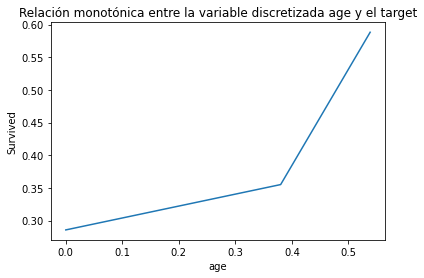

In [15]:
# Relación monotónica con el target: set prueba

pd.concat([test_t, y_test], axis=1).groupby(['age'])['survived'].mean().plot()
plt.title('Relación monotónica entre la variable discretizada age y el target')
plt.ylabel('Survived')

El árbol mantuvo la relación monotónica entre los intervalos y el target. Debemos admitir que tuvimos que intentar bastantes parámetros del árbol para encontrar el óptimo que mantuviesa la relación monotónica. 

Text(0, 0.5, 'Survived')

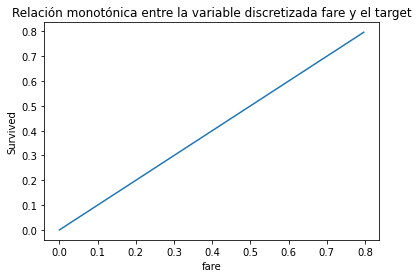

In [16]:
# exploremos la relación monotónica para la variable fare
pd.concat([train_t, y_train], axis=1).groupby(['fare'])['survived'].mean().plot()
plt.title('Relación monotónica entre la variable discretizada fare y el target')
plt.ylabel('Survived')

Text(0, 0.5, 'Survived')

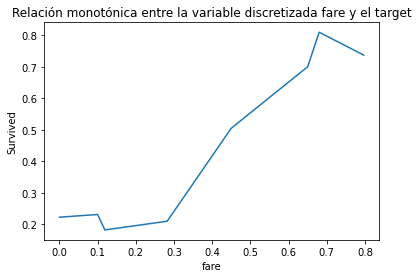

In [17]:
# Relación monotónica con el target: set prueba

pd.concat([test_t, y_test], axis=1).groupby(['fare'])['survived'].mean().plot()
plt.title('Relación monotónica entre la variable discretizada fare y el target')
plt.ylabel('Survived')

Para la variable fare, la relación monotónica fue preservada, casi en tu totatlidad, a excepción de los bordes, lo cual sugiere que el árbol puede estar sobre-ajustando el set de entrenamiento.

Text(0, 0.5, 'Proporción de observaciones por intervalo')

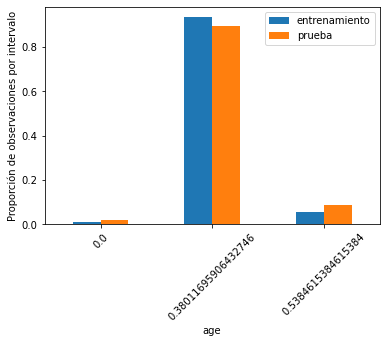

In [18]:
# exploremos cuantas observaciones tenemos por intervalo

t1 = train_t.groupby(['age'])['age'].count() / len(train_t)
t2 = test_t.groupby(['age'])['age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['entrenamiento', 'prueba']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Proporción de observaciones por intervalo')

Muchas de las observaciones estan en el intervalo medio, lo cual indica que la variable no tiene mucho poder predictivo para este target. 

Text(0, 0.5, 'Proporción de observaciones por intervalo')

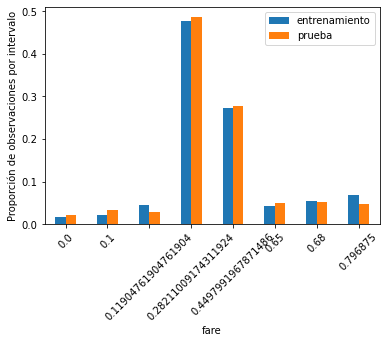

In [19]:
# exploremos cuantas observaciones tenemos por intervalo

t1 = train_t.groupby(['fare'])['fare'].count() / len(train_t)
t2 = test_t.groupby(['fare'])['fare'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['entrenamiento', 'prueba']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Proporción de observaciones por intervalo')

Para la variable fare, el árbol dividió los valores en más intervalos, por lo tanto creando una mejor distribución de los valores (recuerda que la variable fare estaba bastante sesgada).